# Machine-Learning tabular models approach general model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

Load the data

In [2]:
df = pd.read_csv("Data/Processed/data.csv").drop(['steps'], axis=1)

In [3]:
df.describe()

,index,glucose,calories,heart_rate,basal_rate,bolus_volume_delivered,carb_input,glucose_t+1
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,99.50000,138.784993,8.199176,74.248981,0.053784,0.048930,0.113100,138.899309
std,57.74008,62.546454,5.685092,15.072839,0.040765,0.577037,2.618822,62.553828
min,0.00000,40.000000,3.918500,42.920000,0.000000,0.000000,0.000000,40.000000
25%,49.75000,89.666667,4.656000,63.512246,0.021000,0.000000,0.000000,89.666667
50%,99.50000,130.000000,6.141110,71.680741,0.066000,0.000000,0.000000,130.000000
75%,149.25000,182.000000,9.038620,84.549124,0.075000,0.000000,0.000000,182.000000
max,199.00000,337.000000,86.498001,163.785714,0.250000,15.400000,100.000000,337.000000


In [4]:
X = df.drop(['glucose_t+1', 'index'], axis=1)
y = df['glucose_t+1']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

## Random Forest Regressor

In [6]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

Train

In [7]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Test

In [8]:
y_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=y_pred)

In [9]:
rmse

6.427477354000442

In [10]:
feature_importances = rf.feature_importances_

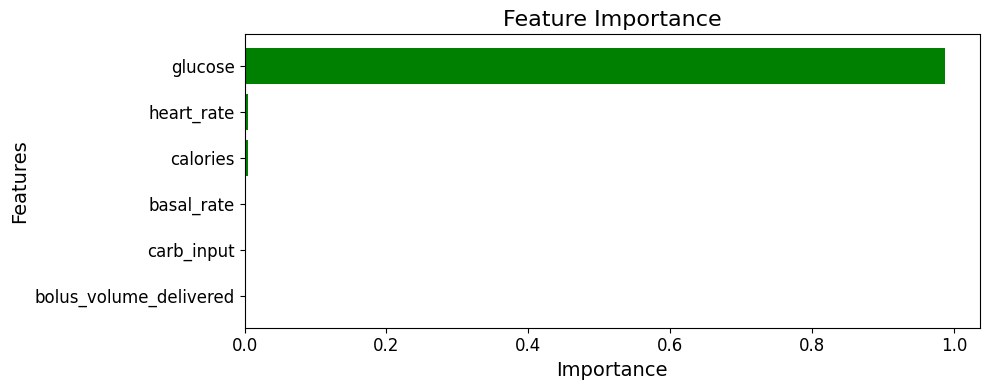

In [11]:
sorted_idx = np.argsort(feature_importances)
sorted_features = X_train.columns[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(10, 4))
plt.barh(sorted_features, sorted_importances, color='green')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=12)
plt.tight_layout()

## Gradient boosting regressor

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

params = {
    'loss' : 'squared_error',
    'learning_rate' : 0.05,
    'random_state' : 42,
    'n_estimators' : 200
}
gbrt = GradientBoostingRegressor(**params)

In [13]:
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42)

In [14]:
y_pred_gbrt = gbrt.predict(X_test)
rmse_gbrt = root_mean_squared_error(y_true=y_test, y_pred = y_pred_gbrt)

In [15]:
rmse_gbrt

5.887139068946089

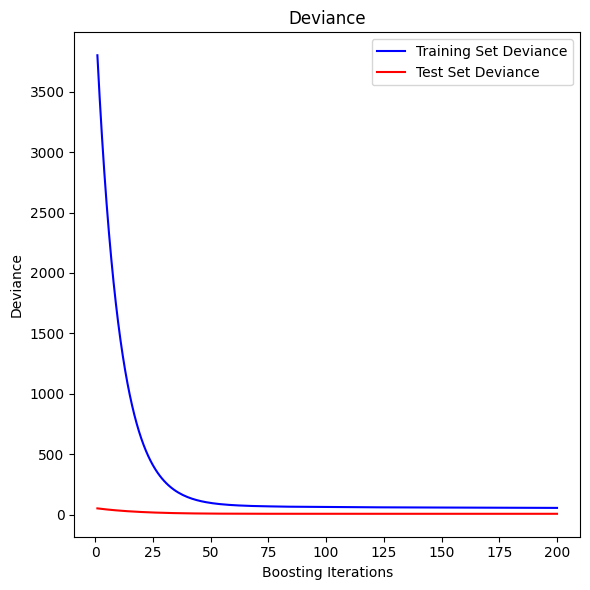

In [16]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbrt.staged_predict(X_test)):
    test_score[i] = root_mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbrt.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()

In [17]:
import matplotlib
from sklearn.utils.fixes import parse_version
from sklearn.inspection import permutation_importance

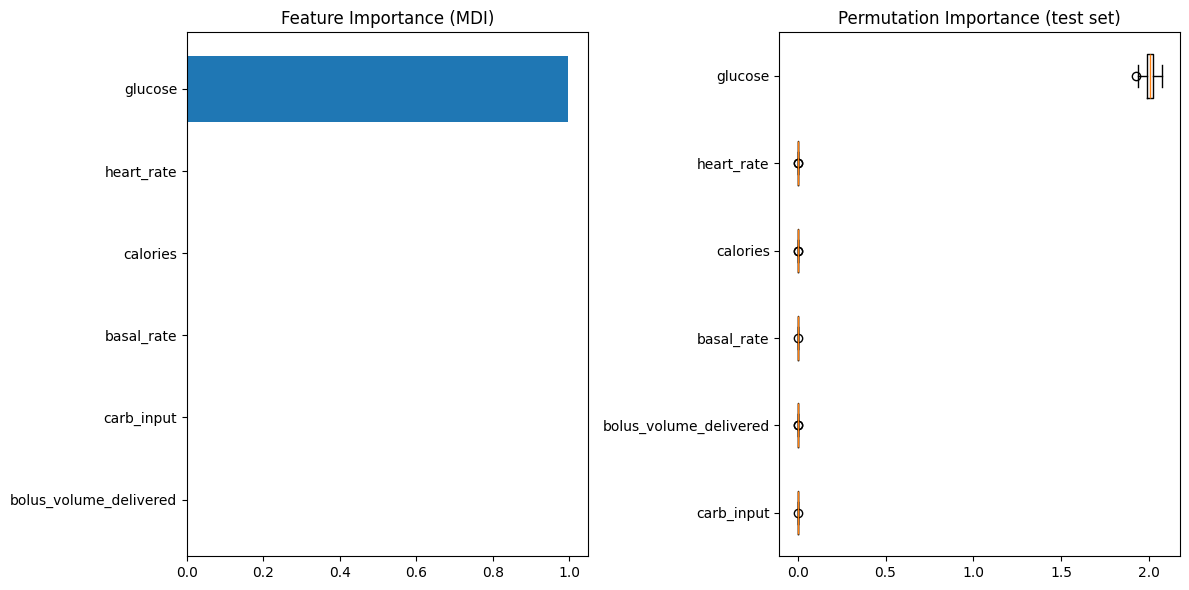

In [18]:
feature_importance = gbrt.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbrt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)

# `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
# renamed to `tick_labels`. The following code handles this, but as a
# scikit-learn user you probably can write simpler code by using `labels=...`
# (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
tick_labels_parameter_name = (
    "tick_labels"
    if parse_version(matplotlib.__version__) >= parse_version("3.9")
    else "labels"
)
tick_labels_dict = {
    tick_labels_parameter_name: np.array(X_train.columns)[sorted_idx]
}
plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()